In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['plates', 'sample_submission.csv']


In [2]:
data_root = '../input/plates/plates/'
print(os.listdir(data_root))

['train', 'test']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 616.13it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(4, 32)

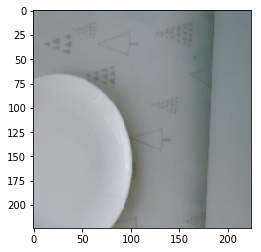

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

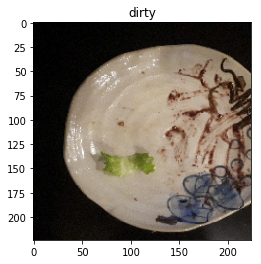

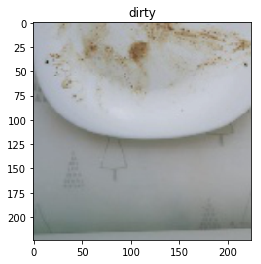

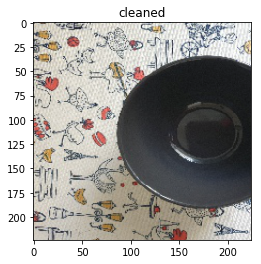

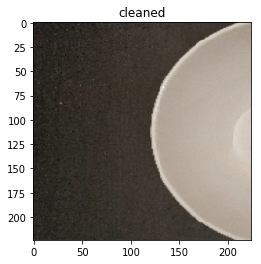

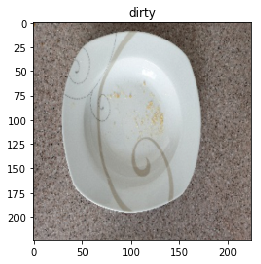

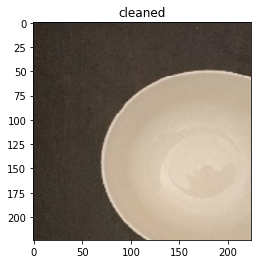

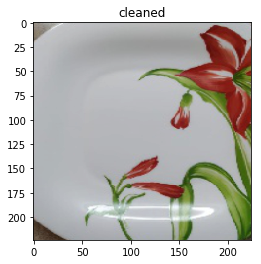

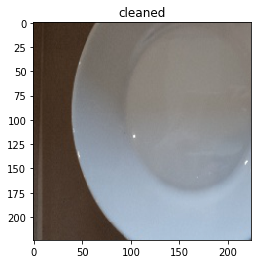

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 101646482.04it/s]


In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]

train Loss: 0.7742 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

val Loss: 0.5820 Acc: 0.5000
Epoch 1/99:



100%|██████████| 4/4 [00:00<00:00,  6.92it/s]

train Loss: 0.7540 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

val Loss: 0.5366 Acc: 0.8750
Epoch 2/99:



100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

train Loss: 0.7380 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

val Loss: 0.6003 Acc: 0.5000
Epoch 3/99:



100%|██████████| 4/4 [00:00<00:00,  7.03it/s]

train Loss: 0.6615 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

val Loss: 0.6595 Acc: 0.5000
Epoch 4/99:



100%|██████████| 4/4 [00:00<00:00,  7.01it/s]

train Loss: 0.6069 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

val Loss: 0.5705 Acc: 0.6250
Epoch 5/99:



100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

train Loss: 0.5734 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

val Loss: 0.5146 Acc: 0.8750
Epoch 6/99:



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

train Loss: 0.5193 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.5065 Acc: 0.8750
Epoch 7/99:



100%|██████████| 4/4 [00:00<00:00,  6.91it/s]

train Loss: 0.6303 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.5196 Acc: 0.8750
Epoch 8/99:



100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

train Loss: 0.5513 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

val Loss: 0.5221 Acc: 0.8750
Epoch 9/99:



100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

train Loss: 0.5285 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.5255 Acc: 0.8750
Epoch 10/99:



100%|██████████| 4/4 [00:00<00:00,  7.07it/s]

train Loss: 0.5386 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.5324 Acc: 0.8750
Epoch 11/99:



100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

train Loss: 0.5430 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5460 Acc: 0.6250
Epoch 12/99:



100%|██████████| 4/4 [00:00<00:00,  6.98it/s]

train Loss: 0.5230 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

val Loss: 0.5442 Acc: 0.6250
Epoch 13/99:



100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

train Loss: 0.5614 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.5380 Acc: 0.7500
Epoch 14/99:



100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

train Loss: 0.4892 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

val Loss: 0.5252 Acc: 0.8750
Epoch 15/99:



100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

train Loss: 0.5213 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.5196 Acc: 0.7500
Epoch 16/99:



100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

train Loss: 0.5514 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.5383 Acc: 0.7500
Epoch 17/99:



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

train Loss: 0.4969 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

val Loss: 0.5323 Acc: 0.8750
Epoch 18/99:



100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

train Loss: 0.5262 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

val Loss: 0.5215 Acc: 0.8750
Epoch 19/99:



100%|██████████| 4/4 [00:00<00:00,  6.88it/s]

train Loss: 0.4806 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.5149 Acc: 0.8750
Epoch 20/99:



100%|██████████| 4/4 [00:00<00:00,  6.65it/s]

train Loss: 0.5590 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.5155 Acc: 0.8750
Epoch 21/99:



100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

train Loss: 0.5254 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5155 Acc: 0.8750
Epoch 22/99:



100%|██████████| 4/4 [00:00<00:00,  6.92it/s]

train Loss: 0.4982 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

val Loss: 0.5036 Acc: 0.8750
Epoch 23/99:



100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

train Loss: 0.5000 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

val Loss: 0.5119 Acc: 0.8750
Epoch 24/99:



100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

train Loss: 0.4929 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

val Loss: 0.5091 Acc: 0.8750
Epoch 25/99:



100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

train Loss: 0.5857 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.5199 Acc: 0.8750
Epoch 26/99:



100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

train Loss: 0.5483 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

val Loss: 0.5319 Acc: 0.8750
Epoch 27/99:



100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

train Loss: 0.5278 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.5320 Acc: 0.8750
Epoch 28/99:



100%|██████████| 4/4 [00:00<00:00,  7.03it/s]

train Loss: 0.5435 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5325 Acc: 0.8750
Epoch 29/99:



100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

train Loss: 0.5061 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5257 Acc: 0.8750
Epoch 30/99:



100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

train Loss: 0.4979 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

val Loss: 0.5269 Acc: 0.8750
Epoch 31/99:



100%|██████████| 4/4 [00:00<00:00,  6.79it/s]

train Loss: 0.5067 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

val Loss: 0.5328 Acc: 0.8750
Epoch 32/99:



100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

train Loss: 0.5585 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

val Loss: 0.5397 Acc: 0.7500
Epoch 33/99:



100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

train Loss: 0.5661 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

val Loss: 0.5424 Acc: 0.8750
Epoch 34/99:



100%|██████████| 4/4 [00:00<00:00,  6.95it/s]

train Loss: 0.5748 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

val Loss: 0.5504 Acc: 0.7500
Epoch 35/99:



100%|██████████| 4/4 [00:00<00:00,  6.93it/s]

train Loss: 0.5448 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5441 Acc: 0.7500
Epoch 36/99:



100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

train Loss: 0.5328 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

val Loss: 0.5388 Acc: 0.6250
Epoch 37/99:



100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

train Loss: 0.5001 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

val Loss: 0.5270 Acc: 0.8750
Epoch 38/99:



100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

train Loss: 0.5520 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

val Loss: 0.5359 Acc: 0.8750
Epoch 39/99:



100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

train Loss: 0.5358 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.5158 Acc: 0.8750
Epoch 40/99:



100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

train Loss: 0.5446 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5286 Acc: 0.8750
Epoch 41/99:



100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

train Loss: 0.5760 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.5313 Acc: 0.7500
Epoch 42/99:



100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

train Loss: 0.5535 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

val Loss: 0.5409 Acc: 0.7500
Epoch 43/99:



100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

train Loss: 0.5394 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

val Loss: 0.5317 Acc: 0.7500
Epoch 44/99:



100%|██████████| 4/4 [00:00<00:00,  7.05it/s]

train Loss: 0.5331 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

val Loss: 0.5392 Acc: 0.7500
Epoch 45/99:



100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

train Loss: 0.5153 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

val Loss: 0.5306 Acc: 0.6250
Epoch 46/99:



100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

train Loss: 0.4995 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

val Loss: 0.5315 Acc: 0.6250
Epoch 47/99:



100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

train Loss: 0.5084 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.5311 Acc: 0.7500
Epoch 48/99:



100%|██████████| 4/4 [00:00<00:00,  7.07it/s]

train Loss: 0.5574 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

val Loss: 0.5141 Acc: 0.8750
Epoch 49/99:



100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

train Loss: 0.5142 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

val Loss: 0.5143 Acc: 0.8750
Epoch 50/99:



100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

train Loss: 0.5739 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

val Loss: 0.5182 Acc: 0.8750
Epoch 51/99:



100%|██████████| 4/4 [00:00<00:00,  6.87it/s]

train Loss: 0.5583 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

val Loss: 0.5158 Acc: 0.8750
Epoch 52/99:



100%|██████████| 4/4 [00:00<00:00,  6.86it/s]

train Loss: 0.5715 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.5222 Acc: 0.8750
Epoch 53/99:



100%|██████████| 4/4 [00:00<00:00,  6.84it/s]

train Loss: 0.4663 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.5317 Acc: 0.8750
Epoch 54/99:



100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

train Loss: 0.5693 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5300 Acc: 0.8750
Epoch 55/99:



100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

train Loss: 0.4912 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5329 Acc: 0.7500
Epoch 56/99:



100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

train Loss: 0.5553 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

val Loss: 0.5419 Acc: 0.7500
Epoch 57/99:



100%|██████████| 4/4 [00:00<00:00,  6.97it/s]

train Loss: 0.4835 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

val Loss: 0.5184 Acc: 0.8750
Epoch 58/99:



100%|██████████| 4/4 [00:00<00:00,  6.93it/s]

train Loss: 0.5358 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.5142 Acc: 0.8750
Epoch 59/99:



100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

train Loss: 0.5047 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

val Loss: 0.5198 Acc: 0.8750
Epoch 60/99:



100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

train Loss: 0.5607 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

val Loss: 0.5180 Acc: 0.8750
Epoch 61/99:



100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

train Loss: 0.5671 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

val Loss: 0.5308 Acc: 0.8750
Epoch 62/99:



100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

train Loss: 0.5302 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

val Loss: 0.5255 Acc: 0.8750
Epoch 63/99:



100%|██████████| 4/4 [00:00<00:00,  6.84it/s]

train Loss: 0.5314 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

val Loss: 0.5259 Acc: 0.8750
Epoch 64/99:



100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

train Loss: 0.5176 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

val Loss: 0.5353 Acc: 0.8750
Epoch 65/99:



100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

train Loss: 0.5811 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

val Loss: 0.5299 Acc: 0.7500
Epoch 66/99:



100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

train Loss: 0.5347 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

val Loss: 0.5203 Acc: 0.8750
Epoch 67/99:



100%|██████████| 4/4 [00:00<00:00,  6.98it/s]

train Loss: 0.5512 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

val Loss: 0.5248 Acc: 0.8750
Epoch 68/99:



100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

train Loss: 0.5780 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

val Loss: 0.5195 Acc: 0.8750
Epoch 69/99:



100%|██████████| 4/4 [00:00<00:00,  7.03it/s]

train Loss: 0.5400 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

val Loss: 0.5389 Acc: 0.8750
Epoch 70/99:



100%|██████████| 4/4 [00:00<00:00,  7.13it/s]

train Loss: 0.5880 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

val Loss: 0.5320 Acc: 0.8750
Epoch 71/99:



100%|██████████| 4/4 [00:00<00:00,  6.73it/s]

train Loss: 0.5438 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

val Loss: 0.5190 Acc: 0.8750
Epoch 72/99:



100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

train Loss: 0.5200 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

val Loss: 0.5320 Acc: 0.8750
Epoch 73/99:



100%|██████████| 4/4 [00:00<00:00,  6.95it/s]

train Loss: 0.5794 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

val Loss: 0.5282 Acc: 0.8750
Epoch 74/99:



100%|██████████| 4/4 [00:00<00:00,  6.92it/s]

train Loss: 0.6341 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

val Loss: 0.5247 Acc: 0.8750
Epoch 75/99:



100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

train Loss: 0.5471 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

val Loss: 0.5291 Acc: 0.8750
Epoch 76/99:



100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

train Loss: 0.5626 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

val Loss: 0.5354 Acc: 0.6250
Epoch 77/99:



100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

train Loss: 0.5101 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

val Loss: 0.5212 Acc: 0.8750
Epoch 78/99:



100%|██████████| 4/4 [00:00<00:00,  6.92it/s]

train Loss: 0.4938 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

val Loss: 0.5290 Acc: 0.8750
Epoch 79/99:



100%|██████████| 4/4 [00:00<00:00,  7.02it/s]

train Loss: 0.6433 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

val Loss: 0.5271 Acc: 0.8750
Epoch 80/99:



100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

train Loss: 0.4799 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

val Loss: 0.5343 Acc: 0.8750
Epoch 81/99:



100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

train Loss: 0.5724 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

val Loss: 0.5223 Acc: 0.8750
Epoch 82/99:



100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

train Loss: 0.5533 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

val Loss: 0.5297 Acc: 0.8750
Epoch 83/99:



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

train Loss: 0.5079 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

val Loss: 0.5249 Acc: 0.8750
Epoch 84/99:



100%|██████████| 4/4 [00:00<00:00,  7.03it/s]

train Loss: 0.4828 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

val Loss: 0.5220 Acc: 0.8750
Epoch 85/99:



100%|██████████| 4/4 [00:00<00:00,  6.93it/s]

train Loss: 0.5376 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.5131 Acc: 0.8750
Epoch 86/99:



100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

train Loss: 0.5268 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

val Loss: 0.5208 Acc: 0.7500
Epoch 87/99:



100%|██████████| 4/4 [00:00<00:00,  6.95it/s]

train Loss: 0.5659 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

val Loss: 0.5329 Acc: 0.8750
Epoch 88/99:



100%|██████████| 4/4 [00:00<00:00,  7.05it/s]

train Loss: 0.5434 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.5219 Acc: 0.7500
Epoch 89/99:



100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

train Loss: 0.5413 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

val Loss: 0.5212 Acc: 0.7500
Epoch 90/99:



100%|██████████| 4/4 [00:00<00:00,  6.79it/s]

train Loss: 0.5327 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

val Loss: 0.5207 Acc: 0.7500
Epoch 91/99:



100%|██████████| 4/4 [00:00<00:00,  6.75it/s]

train Loss: 0.5459 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

val Loss: 0.5139 Acc: 0.7500
Epoch 92/99:



100%|██████████| 4/4 [00:00<00:00,  6.98it/s]

train Loss: 0.5212 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

val Loss: 0.5105 Acc: 0.8750
Epoch 93/99:



100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

train Loss: 0.5508 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

val Loss: 0.5082 Acc: 0.8750
Epoch 94/99:



100%|██████████| 4/4 [00:00<00:00,  7.01it/s]

train Loss: 0.5399 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

val Loss: 0.5186 Acc: 0.8750
Epoch 95/99:



100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

train Loss: 0.5370 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

val Loss: 0.5140 Acc: 0.8750
Epoch 96/99:



100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

train Loss: 0.5321 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

val Loss: 0.5225 Acc: 0.8750
Epoch 97/99:



100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

train Loss: 0.4662 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

val Loss: 0.5131 Acc: 0.8750
Epoch 98/99:



100%|██████████| 4/4 [00:00<00:00,  6.61it/s]

train Loss: 0.5117 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

val Loss: 0.5169 Acc: 0.8750
Epoch 99/99:



100%|██████████| 4/4 [00:00<00:00,  6.59it/s]

train Loss: 0.5525 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

val Loss: 0.5276 Acc: 0.8750


In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [14]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 27.10it/s]


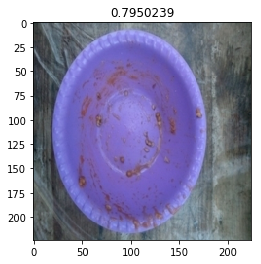

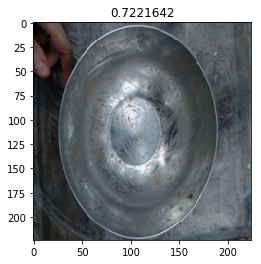

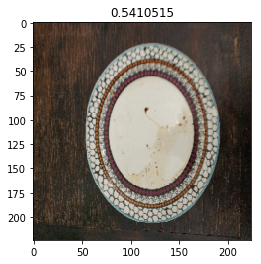

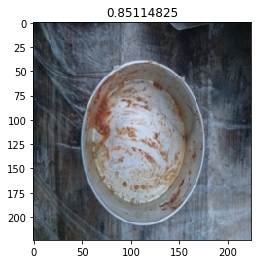

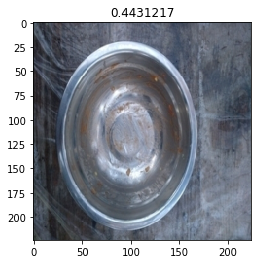

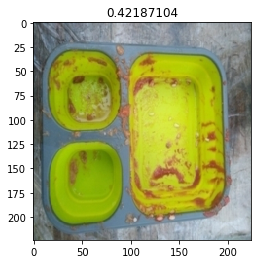

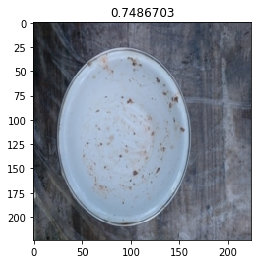

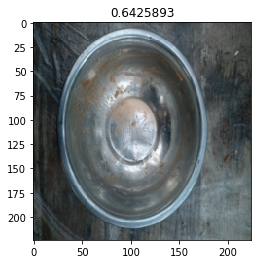

In [15]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [16]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [17]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,cleaned
0005,cleaned


In [18]:
submission_df.to_csv('submission.csv')

In [19]:
!rm -rf train val test